# MATH 497: Final Project Solution


## Questions during the presentation

### Selected 5 questions:

### 1. Can you change $J$ in the multigrid code  to  5 and run the code?

### 2.  Please briefly explain the values of mini-batch size and number of iterations in one epoch. How are they related? 

### 3.  How to change the learning rate schedule to: divided the learning rate by 2 every 20 epochs?

### 4. How will changing the number of channels affect the complexity (i.e number of parameters) of the model?

### 5. What are the differences between Multigrid codes and MgNet codes? List three differences.


### Other questions

### 1. What is the training algorithm you used for training the MgNet results. Please briefly explain some hyper-parameters of this training algorithms such as: mini-batch size, learning rate.


### 2. How do you apply the operation of convolution $f^l-A_l * u^l$ in your code? 

### 3. How are the batch size and number of iterations related? 

### 4. What is the order of activation function and batch normalization in MgNet/


### 5. Define a MgNet, which has 5 layers and the number of iterations for the first layer is 2 and the numbers of iterations for the other layers are all 1.

### 6. How do you think about the result to reduce the channel for both $u$ and $f$ to 32, meanwhile, how about increase the channel to 1024?

### 7. How will changing the number of channels affect the complexity (i.e number of parameters) of the model?


### 8. Can you make a conclusion about the corresponding effects for tuning each parameter?

### 9. Can you explain the purpose of the training-validation split? 

=================================================================================================================

## Problem 1 [20%]:  

Consider the following linear system

\begin{equation}\label{matrix}
A\ast u =f,
\end{equation}
or equivalently $u=\arg\min \frac{1}{2} (A* v,v)_F-(f,v)_F$, where $(f,v)_F =\sum\limits_{i,j=1}^{n}f_{i,j}v_{i,j}$ is the Frobenius inner product.
Here $\ast$ represents a convolution with one channel, stride one and zero padding one. The convolution kernel $A$ is given by
$$ 
A=\begin{bmatrix} 0 & -1 & 0 \\ -1 & 4 & -1 \\ 0 & -1 & 0 \end{bmatrix},~~
$$
the solution $ u \in \mathbb{R}^{n\times n} $, and the RHS $ f\in \mathbb{R}^{n\times n}$ is given by $f_{i,j}=\dfrac{1}{(n+1)^2}.$


### Tasks:
Set $J=4$, $n=2^J-1$ and the number of iterations $M=100$. Use the gradient descent method and the multigrid method to solve the above problem with a random initial guess $u^0$. Let $u_{GD}$ and $u_{MG}$ denote the solutions obtained by gradient descent and multigrid respectively.
    
* [5%] Plot the surface of solution $u_{GD}$ and $u_{MG}$.

* [10%] Define error $e_{GD}^m = \|A * u^{m}_{GD}- f\|_F=\sqrt{\sum\limits_{i=1}^{n}\sum\limits_{j=1}^{n} |(A * u^{m}_{GD}- f)_{i,j}}|^2 $ for $m=0,1,2,3,...,M$. Similarly, we define the multigrid error $e_{MG}^m$. Plot the errors $e_{GD}^m$ and $e_{MG}^m$ as a function of the iteration $m$ (your x-axis is $m$ and your y-axis is the error). Put both plots together in the same figure.

* [5%] Find the minimal $m_1$ for which $e^{m_1}_{GD} <10^{-5}$ and the minimal $m_2$ for which $e^{m_2}_{MG} <10^{-5}$, and report the computational time for each method. Note that $m_1$ or $m_2$ may be greater than $M=100$, in this case you will have to run more iterations.

### Remark:

Below are examples of using gradient descent and multigrid iterations for M-times 
* #### For gradient descent method with $\eta=\frac{1}{8}$, you need to write a code:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~\text{for    }  i,j = 1: n\\
&~~~~~~~~u_{i,j}^{m} = u_{i,j}^{m-1}-\eta(f_{i,j}-(A\ast u^{m-1})_{i,j})\\
&~~~~\text{endfor}\\
&\text{endfor}
\end{align} 
$$

* #### For multigrid method, we have provided the framework code in F02_MultigridandMgNet.ipynb:

    Given initial guess $u^0$
$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~u^{m} = MG1(u^{m-1},f, J, \nu)\\
&\text{endfor}
\end{align} 
$$

## Results of Problem 1:


In [25]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from timeit import default_timer as timer

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


    
##### For MG: inilization of A, S, Pi, R, RT #####
def get_mg_init(A=None, S=None, Pi=None, R=None, RT=None):

    A_kernel = torch.tensor([[[[0,-1,0],[-1,4,-1],[0,-1,0]]]],dtype=torch.float32)
    #S_kernel = torch.tensor([[[[0,1/64,0],[1/64,12/64,1/64],[0,1/64,0]]]],dtype=torch.float32) # multigrid
    S_kernel = torch.tensor([[[[0,0,0],[0,1/8,0],[0,0,0]]]],dtype=torch.float32) # gradient descent method
    Pi_kernel = torch.tensor([[[[0,0,0],[0,0,0],[0,0,0]]]],dtype=torch.float32)
    R_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)
    RT_kernel = torch.tensor([[[[0,0.5,0.5],[0.5,1,0.5],[0.5,0.5,0]]]],dtype=torch.float32)

    if A is not None:
        A.weight = torch.nn.Parameter(A_kernel)
    
    if S is not None:
        S.weight = torch.nn.Parameter(S_kernel)
        
    if Pi is not None:
        Pi.weight = torch.nn.Parameter(Pi_kernel)
    
    if R is not None:
        R.weight = torch.nn.Parameter(R_kernel)
    
    if RT is not None:
        RT.weight = torch.nn.Parameter(RT_kernel)
    
    return

##### For MG: setup for prolongation and error calculation #####
RT = nn.ConvTranspose2d(1, 1, kernel_size=3, stride=2, padding=0, bias=False)
get_mg_init(None,None,None,None,RT)
A = nn.Conv2d(1, 1, kernel_size=3,stride=1, padding=1, bias=False)
get_mg_init(A,None,None,None,None)


class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        
        get_mg_init(A=A,S=S)                       ##### For MG: inilization of A, S #####

        self.A = A
        self.S = S

    
    def forward(self, out):
        u, f = out
        u = u + (self.S(((f-self.A(u)))))                                   ##### For MG: S*(f-A*u) #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()

        get_mg_init(A=A,Pi=Pi,R=R)            ##### For MG: inilization of A, Pi, R #####

        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R


    def forward(self, out):
        u_old, f_old = out
        u = self.Pi(u_old)                              ##### For MG: u = Pi*u_old #####
        f = self.R(f_old-self.A_old(u_old)) + self.A(u) ##### For MG: f = R*(f_old-A*u) #####     
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
              

        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration):
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

                ##### For MG: padding=0 #####  
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=0, bias=False)
                R  = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=0, bias=False)                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        

    def forward(self, u, f):
        out = (u, f) 

        u_list.append(u)                                      ##### For MG: save u^j, j=1,2,...,J #####
        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
            u, f = out                                        ##### For MG: save u^j, j=1,2,...,J #####
            u_list.append(u)                                  ##### For MG: save u^j, j=1,2,...,J #####
        
        return u                                        
    
    

Use GPU? False


In [26]:
def plot_solution(J,u,label_name):
    N = 2 ** J -1
    h = 1/2**J
    X = np.arange(h, 1, h)
    Y = np.arange(h, 1, h)
    X, Y = np.meshgrid(X,Y)
    a = torch.reshape(u, (N, N))
    fig1 = plt.figure()
    ax = Axes3D(fig1)
    ax.plot_surface(X, Y, np.array(a.data), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
    ax.set_title(label_name)

    
def plot_error(M,error,label_name):
    plt.figure()
    plt.title('Error vs number of iterations using '+label_name)
    plot = plt.plot(error)
    plt.xlabel('Number of iterations')
    plt.yscale('log')
    plt.ylabel('Error')
    plt.show()

In [27]:
def MG1(u,f,J,num_iteration):
    u_list.clear()                                     # Save u^0,u^1,u^2,u^3...,u^J
    u = MG0(u,f)
    for j in range(J-1,0,-1):
        u_list[j] += RT(u_list[j+1])
    u = u_list[1]
    return u

## Task 1


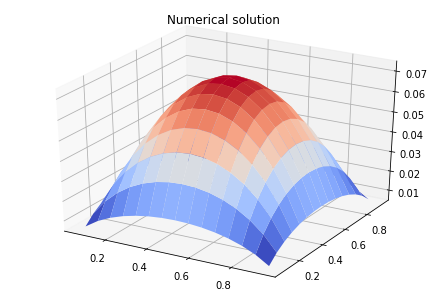

In [40]:
# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 
num_iteration = [2,2,2,2]
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

##### For MG: PDE setup u=sin(2*pi*x)*sin(2*pi*y) #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Muligrid iteration #####
M = 100
u = torch.randn(1,1,N,N)
error = [np.linalg.norm((A(u)-f).detach().numpy())]  # calculate the Frobenius Norm of (A*u-f)
u_list =[]                                     # Save u^0,u^1,u^2,u^3...,u^J

for m in range(M):
    u = MG1(u,f,J,num_iteration)
    error.append(np.linalg.norm((A(u)-f).detach().numpy())) # calculate the Frobenius Norm of (A*u-f)


##### Lian added for MG: Plot results #####
plot_solution(J,u,'Numerical solution')

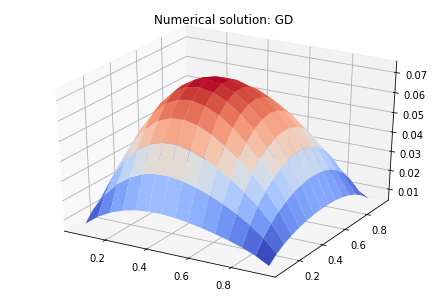

In [20]:
# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 4 
num_iteration = [1,0,0,0]
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

##### For MG: PDE setup u=sin(2*pi*x)*sin(2*pi*y) #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Muligrid iteration #####
M = 100
u = torch.randn(1,1,N,N)
error_gd = [np.linalg.norm((A(u)-f).detach().numpy())]

for m in range(M):
    u_list = []
    u = MG0(u,f)
    for j in range(J-1,0,-1):
        u_list[j] += RT(u_list[j+1])
    u = u_list[1]
    error_gd.append(np.linalg.norm((A(u)-f).detach().numpy()))


##### Lian added for MG: Plot results #####
plot_solution(J,u,'Numerical solution: GD')

### Task 2

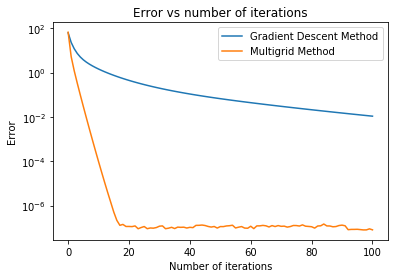

In [21]:
plt.figure()
plt.title('Error vs number of iterations')
plot = plt.plot(error_gd,label='Gradient Descent Method')
plot = plt.plot(error_mg,label='Multigrid Method')
plt.xlabel('Number of iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.legend()
plt.show()

### Task 3

In [ ]:
# Model setup
num_channel_input = 1
num_channel_u = 1
num_channel_f = 1
num_classes = 1 

J = 5 
num_iteration = [1,0,0,0,0]  
MG0=MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

##### For MG: setup  #####

N = 2 ** J -1
h = 1/2**J
u_exact = torch.ones(1,1,N,N)
f = torch.ones(1,1,N,N) / (N+1) **2


##### For MG: Muligrid iteration #####
M = 10000
u = torch.randn(1,1,N,N)
error_gd = [np.linalg.norm((A(u)-f).detach().numpy())]

start_gd = timer()
for m in range(M):
    if error_gd[-1]>1e-5:
        u = MG1(u,f,J,num_iteration)
        error_gd.append(np.linalg.norm((A(u)-f).detach().numpy()))
    else:
        break
end_gd = timer()

print('For GD method, the minimum number of iterations to achieve less than 1e-5 error is:{}, and the computational time is: {}'.format(m, end_gd-start_gd))

plot_error(M,error_gd,'GD')



### The following table shows the results of the Task 3:

    

| Method           | $\nu$ or $\eta$ | #iterations    | computational time  |
|:-----------------|:----------------|:---------------|:--------------------|
| Gradient descent | $$\eta = 1/8$$  |     985        | 1.0484s             |
| Iterative Method | [2,0,0,0]       |     193        | 0.2696s             |
| Multigrid        | [2,2,2,2]       |     13         | 0.05071s            |

### If we change J to 5, we have the following results

| Method           | $\nu$ or $\eta$ | #iterations    | computational time  |
|:-----------------|:----------------|:---------------|:--------------------|
| Gradient descent | $$\eta = 1/8$$  |     1740       | 2.4592s             |
| Iterative Method | [2,0,0,0]       |     597        | 0.9560              |
| Multigrid        | [2,2,2,2]       |     14         | 0.0504s             |

### Discussions or Conclusions

#### *   For a fixed numer of iterations, $e_{MD}^m$ is much less than $e_{GD}^m$.
#### *   For a fixed error, multigrid needs much less iterations than gradient method.


=================================================================================================================

## Problem 2 [50%]: 

Use SGD with momentum and weight decay to train MgNet on the Cifar10 dataset. Use 120 epochs, set the initial learning rate to 0.1, momentum to 0.9, weight decay to 0.0005, and divide the learning rate by 10 every 30 epochs. (The code to do this has been provided.) Let $b_i$ denote the test accuracy of the model after $i$ epochs, and let $b^*$ = $\max_i(b_i)$ be the best test accuracy attained during training.


### Tasks:
   * [30%] Train MgNet with the following three sets of hyper-parameters (As a reminder, the hyper-parameters of MgNet are $\nu$, the number of iterations of each layer, $c_u$, the number of channels for $u$, and $c_f$, the number of channels for $f$.):
 
    (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.
    
    (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

    (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, try to improve the test accuracy by implementing MgNet with $S^{l,i}$, which means different iterations in the same layer do not share the same $S^{l}$. 
  
  
   * For each numerical experiment above, print the results with the following format:

       "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

        where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.
    
    
   * [10%] For each numerical experiment above, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. An example plot is shown in the next cell.
   
   
   * [10%] Calculate the number of parameters that each of the above models has. Discuss why the number of parameters is different (or the same) for each of the models.
       

## Results of Problem 2:


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


    



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        

        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()


        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                layers.append(MgIte(A, S))

            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)


                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
       
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        
    
    

### For (1) $\nu=$[1,1,1,1], $c_u=c_f=64$.

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10 
num_iteration = [1,1,1,1]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

test_accuracy_list = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    test_accuracy_list.append(test_accuracy)
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,  test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)

In [ ]:
# Show the print and plots

### For (2) $\nu=$[2,2,2,2], $c_u=c_f=64$.

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10 
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

test_accuracy_list = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    test_accuracy_list.append(test_accuracy)
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,  test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)

In [ ]:
# Show the print and plots

### For (3) $\nu=$[2,2,2,2], $c_u=c_f=64$, MgNet with $S^{l,i}$


In [ ]:
import torch
import numpy as np
import torch.nn as nn
import  torch.nn.functional as F
import torch.optim as optim
import torchvision
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)


    



class MgIte(nn.Module):
    def __init__(self, A, S):
        super().__init__()
        

        self.A = A
        self.S = S

        self.bn1 =nn.BatchNorm2d(A.weight.size(0)) ##### For MgNet: BN #####
        self.bn2 =nn.BatchNorm2d(S.weight.size(0)) ##### For MgNet: BN #####
    
    def forward(self, out):
        u, f = out
        u = u + F.relu(self.bn2(self.S(F.relu(self.bn1((f-self.A(u))))))) ##### For MgNet: add BN and ReLU #####
        out = (u, f)
        return out



class MgRestriction(nn.Module):
    def __init__(self, A_old, A, Pi, R):
        super().__init__()


        self.A_old = A_old
        self.A = A
        self.Pi = Pi
        self.R = R

        self.bn1 = nn.BatchNorm2d(Pi.weight.size(0))   ##### For MgNet: BN #####
        self.bn2 = nn.BatchNorm2d(R.weight.size(0))    ##### For MgNet: BN #####

    def forward(self, out):
        u_old, f_old = out
        u = F.relu(self.bn1(self.Pi(u_old)))                              ##### For MgNet: add BN and ReLU #####
        f = F.relu(self.bn2(self.R(f_old-self.A_old(u_old)))) + self.A(u) ##### For MgNet: add BN and ReLU #####        
        out = (u,f)
        return out


class MG(nn.Module):
    def __init__(self, num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes):
        super().__init__()
        self.num_iteration = num_iteration
        self.num_channel_u = num_channel_u
        
        ##### For MgNet: Initialization layer #####
        self.conv1 = nn.Conv2d(num_channel_input, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channel_f)        

        
        A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3, stride=1, padding=1, bias=False)
        #S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)

        layers = []
        for l, num_iteration_l in enumerate(num_iteration): #l: l-th layer.   num_iteration_l: the number of iterations of l-th layer
            for i in range(num_iteration_l):
                S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)
                layers.append(MgIte(A, S))


            setattr(self, 'layer'+str(l), nn.Sequential(*layers))
            # set attribute. This is equivalent to define
            # self.layer1 = nn.Sequential(*layers)
            # self.layer2 = nn.Sequential(*layers)
            # ...
            # self.layerJ = nn.Sequential(*layers)


            if l < len(num_iteration)-1:
                A_old = A
                
                A = nn.Conv2d(num_channel_u, num_channel_f, kernel_size=3,stride=1, padding=1, bias=False)
                #S = nn.Conv2d(num_channel_f, num_channel_u, kernel_size=3,stride=1, padding=1, bias=False)


                ##### For MgNet: padding=1 #####
                Pi = nn.Conv2d(num_channel_u, num_channel_u, kernel_size=3,stride=2, padding=1, bias=False)
                R = nn.Conv2d(num_channel_f, num_channel_f, kernel_size=3, stride=2, padding=1, bias=False)
                
                
                layers= [MgRestriction(A_old, A, Pi, R)]
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        self.pooling = nn.AdaptiveAvgPool2d(1)  # pooling the data in each channel to size=1
        self.fc = nn.Linear(num_channel_u ,num_classes)

    def forward(self, u, f):
        f = F.relu(self.bn1(self.conv1(f)))                 ##### For MgNet: initialization of f #####
        if use_cuda:                                        ##### For MgNet: initialization of u #####
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3), device=torch.device('cuda'))
        else:
            u = torch.zeros(f.size(0),self.num_channel_u,f.size(2),f.size(3))        
       
        
        out = (u, f) 

        for l in range(len(self.num_iteration)):
            out = getattr(self, 'layer'+str(l))(out) 
        
        ##### For MgNet: average pooling and fully connected layer for classification #####
        u, f = out       
        u = self.pooling(u)
        u = u.view(u.shape[0], -1)
        u = self.fc(u)
        return u                                        
    
    

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 64
num_channel_f = 64
num_classes = 10 
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

test_accuracy_list = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    test_accuracy_list.append(test_accuracy)
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,  test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)

In [ ]:
# Show the print and plots

### Summary 

|      Model            | $$c_u,c_f$$| $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:----------------------|:-----------|:-----------|:--------------------|:------------------|:------------|
| MgNet with $S^{l}$    |   64,64    |  [1,1,1,1] |      91.7           |   1~2 hours       |             |
| MgNet with $S^{l}$    |   64,64    |  [2,2,2,2] |      92.5           |   1~2 hours       |   521418    |
| MgNet with $S^{l,i}$  |   64,64    |  [2,2,2,2] |      93.1           |                   |             |

### Discussions or Conclusions

#### *  With fixed $c_u$ and $c_f$, the test accuracy improves if we increase  $\nu$
#### * With fixed $c_u$, $c_f$ and $\nu$, MgNet with $S^{l,i}$ achieves better test accuracy than it with $S^{l}$

=================================================================================================================

## Problem 3 [25 %]:

Try to improve the MgNet Accuracy by increasing the number of channels. (We use the same notation as in the previous problem.) Double the number of channels to $c_u=c_f=128$ and try different $\nu$ to maximize the test accuracy.

### Tasks:
   * [20%] Report $b^{*}$, $\nu$ and the number of parameters of your model for each of the experiments you run.
   * [5%] For the best experiment, plot the test accuracy against the epoch count, i.e. the x-axis is the number of epochs $i$ and y-axis is the test accuracy $b_i$. (Same as for the previous problem.)

### Summary 

|      Model            | $$c_u,c_f$$| $\nu$      | test accuracy $b^*$ |computational time | #parameters |
|:----------------------|:-----------|:-----------|:--------------------|:------------------|:------------|
| MgNet |   128,128    |  [1,1,1,1] |      91.7           |   1~2 hours       |           |
| MgNet |   128,128    |  [2,2,2,2] |      92.5           |   1~2 hours       |   521418  |
| MgNet |   128,128    |  [2,2,2,2] |      93.1           |                   |           |

### Discussions or Conclusions

#### *  With fixed $c_u$ and $c_f$, the test accuracy improves if we increase  $\nu$


### For the best experiment, plot the test accuracy against the epoch count

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 128
num_channel_f = 128
num_classes = 10 
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

test_accuracy_list = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    test_accuracy_list.append(test_accuracy)
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,  test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)

=================================================================================================================

## Problem 4 [5%]:

Continue testing larger MgNet models (i.e. increase the number of channels) to maximize the test accuracy. (Again, we use the same notation as in problem 2.)

### Tasks:    
    
+  [5%] Try different training strategies and MgNet architectures with the goal of achieving $b^*>$ 95%. Hint: you can tune the number of epochs, the learning rate schedule, $c_u$, $c_f$, $\nu$, try different $S^{l,i}$ in the same layer $l$, etc...

### Summary 

|    | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
|    |            |           |                     |                   |            |                          |
|    |            |           |                     |                   |            |                          |
|    |            |           |                     |                   |            |                          |


In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

num_channel_input = 3
num_channel_u = 256
num_channel_f = 256
num_classes = 10 
num_iteration = [2,2,2,2]

# Step 1: Define a model
my_model = MG(num_channel_input, num_iteration, num_channel_u, num_channel_f, num_classes)

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

test_accuracy_list = []
#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    start_epoch = timer()

    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    start_training = timer()
    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(0,images)   # We need additional 0 input for u in MgNet
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
    end_training = timer()
    print('Computation Time for training:',end_training - start_training)

  # Training accuracy
    start_training_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(0,images)  # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total
    end_training_acc = timer()
    print('Computation Time for training accuracy:',end_training_acc - start_training_acc)

    
    # Test accuracy
    start_test_acc = timer()
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(0,images)      # We need additional 0 input for u in MgNet
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
    end_test_acc = timer()
    test_accuracy_list.append(test_accuracy)
    print('Computation Time for test accuracy:',end_test_acc - start_test_acc)
    
    print('Epoch: {}, learning rate: {}, the training accuracy {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,  test_accuracy)) 
    end_epoch = timer()
    print('Computation Time for one epoch:',end_epoch - start_epoch)

end = timer()
print('Total Computation Time:',end - start)

### Summary 

|    | $c_u, c_f$ | $\nu$     | test accuracy $b^*$ |computational time | #parameters|other parameters you tuned|
|:---|:-----------|:----------|:--------------------|:------------------|:-----------|:-------------------------|
|    |            |           |                     |                   |            |                          |
|    |            |           |                     |                   |            |                          |
|    |            |           |                     |                   |            |                          |


### Discussions or Conclusions

#### *  
#### *

=================================================================================================================

# Summary of all the problems

## Multigrid and gradient descent method:

### If set J=4, we have the following results


| Method           | $\nu$ or $\eta$ | #iterations    | computational time  |
|:-----------------|:----------------|:---------------|:--------------------|
| Gradient descent | $$\eta = 1/8$$  |     985        | 1.0484s             |
| Iterative Method | [2,0,0,0]       |     193        | 0.2696s             |
| Multigrid        | [2,2,2,2]       |     13         | 0.05071s            |

### If we change J to 5, we have the following results

| Method           | $\nu$ or $\eta$ | #iterations    | computational time  |
|:-----------------|:----------------|:---------------|:--------------------|
| Gradient descent | $$\eta = 1/8$$  |     1740       | 2.4592s             |
| Iterative Method | [2,0,0,0]       |     597        | 0.9560              |
| Multigrid        | [2,2,2,2]       |     14         | 0.0504s             |

### Conclusion:
#### *   For a fixed numer of iterations, $e_{MD}^m$ is much less than $e_{GD}^m$.
#### *   For a fixed error, multigrid needs much less iterations than gradient method.

## MgNet


### Conclusions:
#### * With fixed $\nu$, the test accuracy improves if we increase  $c_u$ and $c_f$

#### *  With fixed $c_u$ and $c_f$, the test accuracy improves if we increase  $\nu$

#### * With fixed $c_u$, $c_f$ and $\nu$, MgNet with $S^{l,i}$ achieves better test accuracy than it with $S^{l}$

